In [114]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from scipy.signal import find_peaks, peak_widths
import astropy.units as u
import numpy as np
import pandas as pd
from collections import defaultdict
from astropy.table import QTable, Table, Column
import math

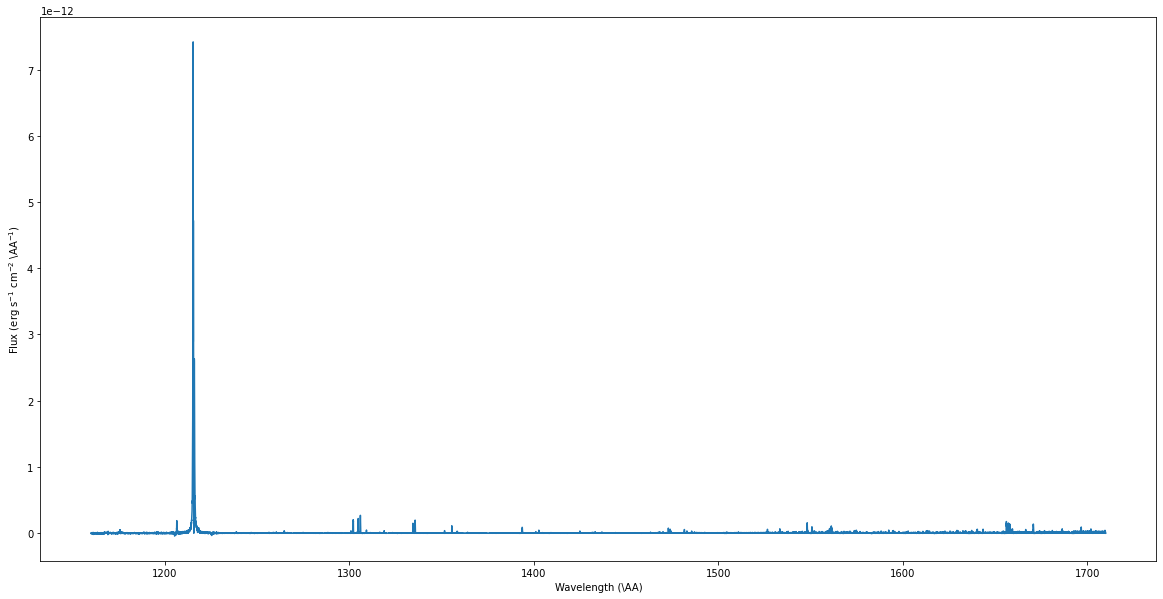

In [115]:
# data sets: (note: og is 27040)
data = fits.getdata('hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits')
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1160
plt.figure(figsize=(20,10))

plt.plot(w[mask], f[mask])


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

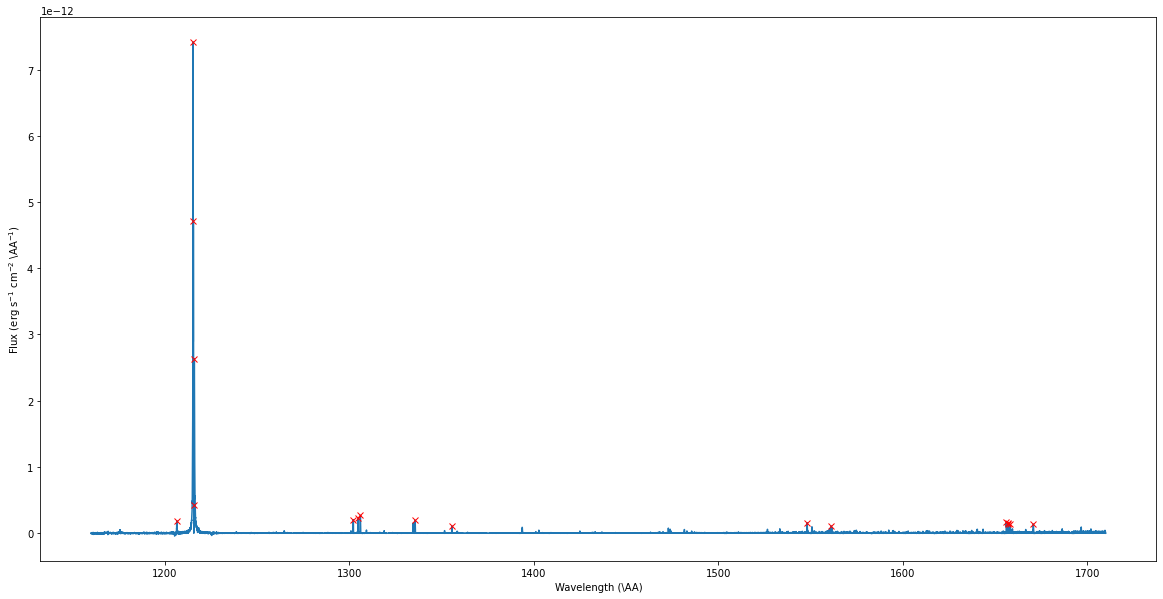

Peak 0: 1206.4409219584277
Peak 1: 1215.3193612053478
Peak 2: 1215.448301194411
Peak 3: 1215.76144116785
Peak 4: 1215.945641152226
Peak 5: 1302.077553846414
Peak 6: 1304.803713615178
Peak 7: 1305.9641735167463
Peak 8: 1335.6387909997097
Peak 9: 1355.5139693138733
Peak 10: 1548.1318929757904
Peak 11: 1561.210091866482
Peak 12: 1656.1099238169645
Peak 13: 1656.7730437607179
Peak 14: 1657.2335437216577
Peak 15: 1657.9519236607239
Peak 16: 1670.6985625795387


In [116]:
# Find peaks
peaks, properties  = find_peaks(f[mask], height = 10*sum(f[mask])/len(f[mask]), prominence = 10*sum(f[mask])/len(f[mask]), width = 0, threshold = (1/10)*sum(f[mask])/len(f[mask]))

plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask])
plt.plot(w[mask][peaks], f[mask][peaks], "xr")
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

# All peaks!
count = 0
for peak in w[mask][peaks]:
    print(f"Peak {count}: {peak}")
    count+=1

In [117]:
# Get rest data
data = pd.read_csv("../DEM_goodlinelist .csv")
df = pd.DataFrame(data)
print(df)

       Ion  Wavelength Likelihood to measure  Log Formation Temperature
0     S VI     933.397                Medium                        5.3
1    N III     989.787                Medium                        4.9
2    N III     991.495                Medium                        4.9
3    N III     991.564                Medium                        4.9
4    Ne VI     999.182                Medium                        5.6
5     O VI    1032.914                Medium                        5.5
6     O VI    1037.615                Medium                        5.5
7   Fe XIX    1118.057                   Low                        6.9
8     Ne V    1145.596                Medium                        5.5
9    C III    1174.935                  High                        4.9
10   C III    1175.265                  High                        4.9
11   C III    1175.592                  High                        4.9
12   C III    1175.713                  High                    

(1300.0, 1350.0)

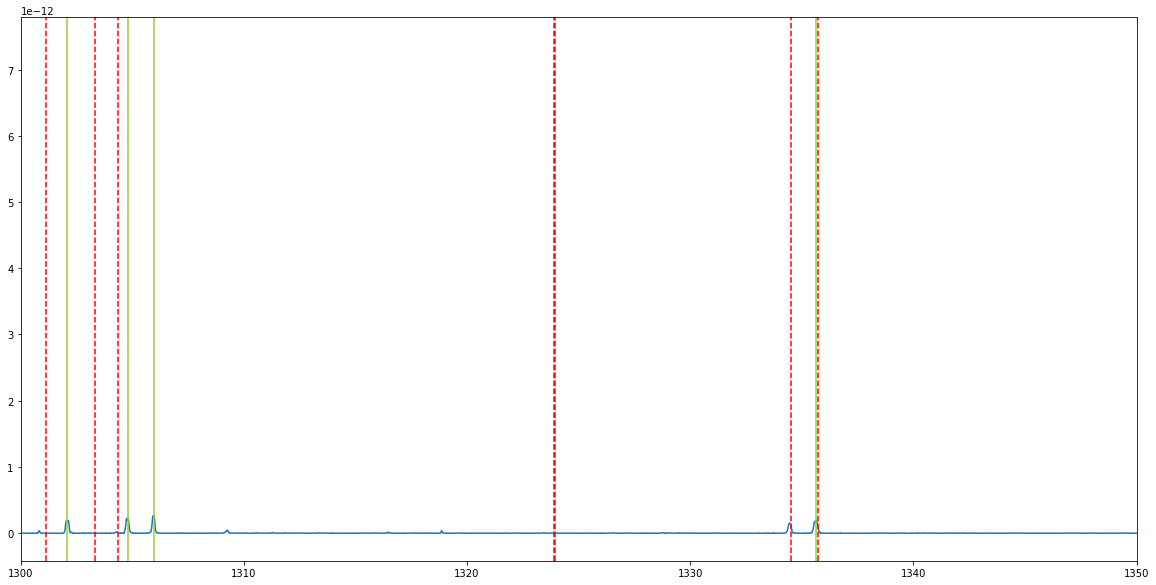

In [118]:
# mask = w > 1250
fig, ax = plt.subplots()
ax.plot(w[mask], f[mask])
fig.set_figheight(10)
fig.set_figwidth(20) 

for line in df['Wavelength']:
    if(line > 1220):
        plt.axvline(x = line, color = 'red', label = 'axvline - full height', linestyle = "--")
    
for peak in w[mask][peaks]:
    plt.axvline(x = peak, color = 'yellowgreen', label = 'axvline - full height')

plt.xlim([1300, 1350]) # add +60

Observed and rest wavelengths for calculations:

1335.6387909997097 1335.709

1526.5804948038058 1526.706

1533.3037942335275 1533.430

1548.1318929757904 1548.201

1550.7106927570535 1550.772 

In [119]:
rest_lam = [1335.709, 1548.201, 1550.772]
obs_lam = [1335.6387909997097, 1548.1318929757904, 1550.7106927570535]
assert len(rest_lam)==len(obs_lam)

In [120]:
dv = []

# First line
u_rest_lam = rest_lam[0] * u.AA
u_obs_lam = obs_lam[0] * u.AA
dv.append(u_obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(u_rest_lam)))

for i in range(1, 3):
    u_rest_lam = rest_lam[i] * u.AA
    u_obs_lam = obs_lam[i] * u.AA
    dv.append(u_obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(u_rest_lam)))
dv[1] = (dv[1] + dv[2])/2
dv.pop()

print(dv)

dv_average = sum(dv)/(len(dv))
print(f"Avg Doppler Shift: {dv_average}")

[<Quantity -15.75801973 km / s>, <Quantity -12.61681872 km / s>]
Avg Doppler Shift: -14.187419222774217 km / s


Current peak estimate: 9.71657153744298
Peak width: 0.35
Flux range: 0.7
Peak width in pixels: 19


(-1e-14, 1.5e-13)

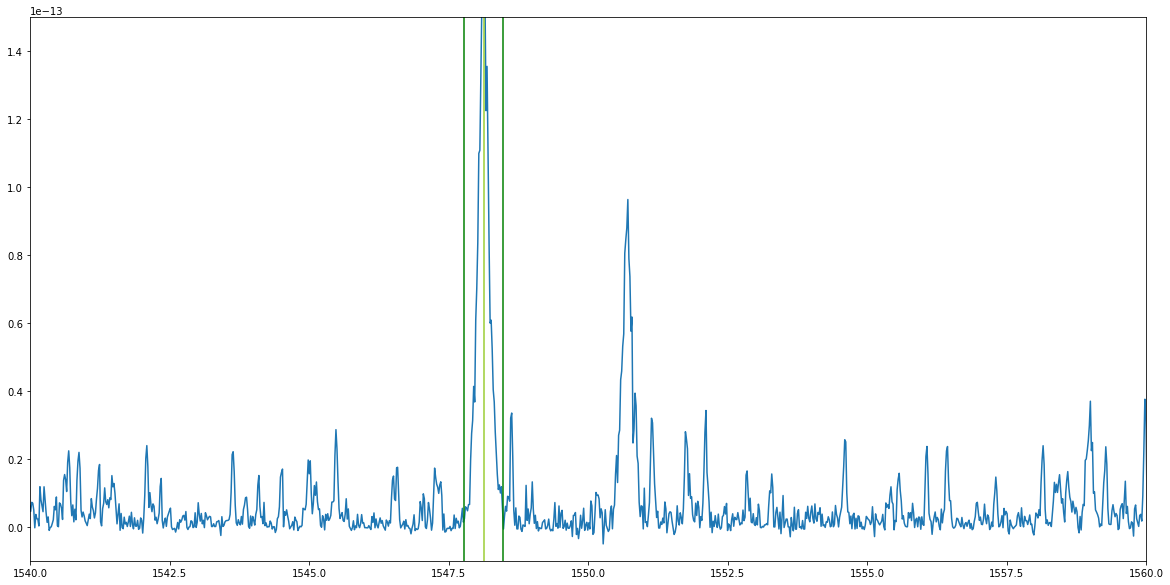

In [121]:
"""
    Peak width finder: first make a guesstimate using peak properties, then refine later
"""
fig, ax = plt.subplots()
ax.plot(w[mask], f[mask])
fig.set_figheight(10)
fig.set_figwidth(20) 

# Make estimate
avg_peak_width = (sum(properties['widths'])/len(properties['widths']))
print(f"Current peak estimate: {avg_peak_width}")

# Refine based on estimated
peak_width = 0.35
print(f"Peak width: {peak_width}")

# Make range 
flux_range = 2*peak_width
print(f"Flux range: {flux_range}")

# Flux range in pixels
angstroms_to_pixels = 0.01841999 
peak_width_pixels = math.floor(peak_width/angstroms_to_pixels)
print(f"Peak width in pixels: {peak_width_pixels}")
    
for peak in w[mask][peaks]:
    plt.axvline(x = peak, color = 'yellowgreen', label = 'axvline - full height')
    plt.axvline(x = peak + peak_width, color = 'green', label = 'axvline - full height')
    plt.axvline(x = peak - peak_width, color = 'green', label = 'axvline - full height')

plt.xlim([1540,1560]) # add +60
plt.ylim([-1e-14, 1.5e-13])

In [122]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) 
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) 
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

In [123]:
def create_trendline_avg(w, f, diff):
    """
    Creates a trendline and returns the function for it using a constant
    """
    length = len(w) - 1
    flux_list = []
    avg_flux = 0
    
    for i in range(0, diff):
        flux_list.append(f[i])
        flux_list.append(f[length-i])
        
    avg_flux = sum(flux_list) / len(flux_list)
    
#     if avg_flux < 0:
#         avg_flux = 0
    if avg_flux > 9e-15:
        avg_flux = 7e-16
    
    flux_array = [avg_flux for i in range(length + 1)]

    wavelength_array = np.array(w)

    z = np.polyfit(w, flux_array, 1)
    p = np.poly1d(z)
    
    plt.plot(wavelength_array, p(wavelength_array), color="red")
    
    return p(wavelength_array) 

In [134]:
"""
    Make a trendline based on the average flux within the mask, without the peak
"""
def create_trendline(w, f, blended_line_bool):
    # Initialize variables
    length = len(w) - 1
    flux_list = []
    
    # Make an array of all flux that aren't included in the peak
    for i in range(0, peak_width_pixels):
        flux_list.append(f[i])
        flux_list.append(f[length-i])
        
    # Find the average flux 
    avg_flux = sum(flux_list)/len(flux_list)
    flux_array = [avg_flux for i in range(length + 1)]
           
    wavelength_array = np.array(w)
    
    z = np.polyfit(w, flux_array, 1)
    p = np.poly1d(z)
    
#     plt.plot(wavelength_array, p(wavelength_array), color="red")
    if blended_line_bool == True:
        plt.plot(wavelength_array, p(wavelength_array), color="blue", alpha=0.6)
    else:
        plt.plot(wavelength_array, p(wavelength_array), color="red", alpha=0.6)
    
    return p(wavelength_array) 

In [125]:
"""
    Make a trendline based on the minimum flux within the mask
"""
def create_trendline_min(w, f, blended_line_bool):
    # Initializing
    length = len(w)
    
    # Find the minimum flux
    flux_min = min(f)
    
    flux_array = [flux_min for i in range(length)]

    wavelength_array = np.array(w)

    z = np.polyfit(w, flux_array, 1)
    p = np.poly1d(z)
    
#     plt.plot(wavelength_array, p(wavelength_array), color="red")

    if blended_line_bool == True:
        plt.plot(wavelength_array, p(wavelength_array), color="blue", alpha=0.6)
    else:
        plt.plot(wavelength_array, p(wavelength_array), color="red", alpha=0.6)
    
    return p(wavelength_array) 

Flux: 3.7620974175847486e-14
Error: 6.42972664191432e-16


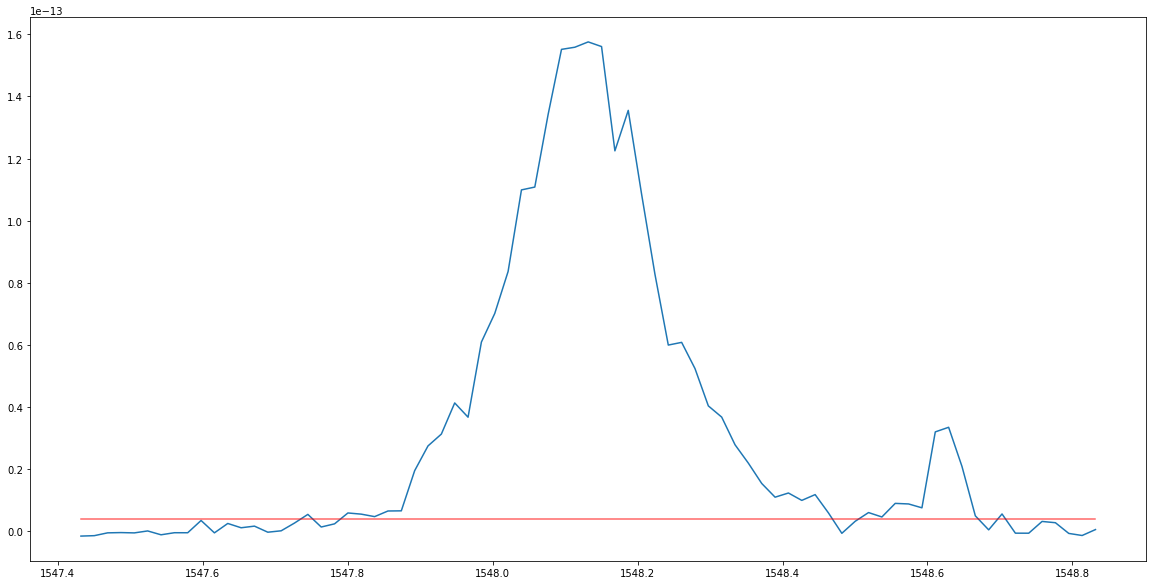

In [135]:
# Mask current peak (use this for the rest!)
wavelength_mask = (w > (w[mask][peaks][10] - flux_range)) & (w < (w[mask][peaks][10] + flux_range))
w0,w1 = wavelength_edges(w[wavelength_mask])
total_sumflux = np.sum(f[wavelength_mask]*(w1-w0))
sumerror = (np.sum(e[wavelength_mask]**2 * (w1-w0)**2))**0.5

plt.figure(figsize=(20,10))
plt.plot(w[wavelength_mask], f[wavelength_mask])


# Continuum calculation
continuum = []
trendline = create_trendline(w[wavelength_mask], f[wavelength_mask], False)

for i in range(0, len(trendline)):
    continuum.append(trendline[i])

continuum_sumflux = np.sum(continuum*(w1-w0))


print(f"Flux: {total_sumflux - continuum_sumflux}")
print(f"Error: {sumerror}")


In [127]:
def check_in_range(val1, val2, x):
    if val1 <= x <= val2:
        return True
    else:
        return False

In [137]:
"""
    Checks if there is a blended line by seeing if the previous peak is within the current obs_lam's range
"""
def blended_line_check(previous_obs, obs_lam, iterations):
    if check_in_range(obs_lam.value - flux_range, obs_lam.value + flux_range, previous_obs.value) and (iterations != 0):
        return True
    else:
        return False

Ion: C III 
('Wavelength: 1176.372', 'Flux: 1.6888561794136553e-14', 'Error: 1.1926804718235693e-15', 'Blended line: True')
Ion: Si III 
('Wavelength: 1206.499', 'Flux: 3.136557575538054e-14', 'Error: 9.488706601250473e-16', 'Blended line: False')
('Wavelength: 1294.543', 'Flux: 5.396106124559057e-16', 'Error: 1.8950087852269928e-16', 'Blended line: False')
('Wavelength: 1296.726', 'Flux: 4.714415201525595e-16', 'Error: 0', 'Blended line: False')
('Wavelength: 1298.944', 'Flux: 5.451521354552725e-16', 'Error: 1.6897341035754562e-16', 'Blended line: True')
('Wavelength: 1301.147', 'Flux: 2.8488914961612034e-15', 'Error: 2.0974133764215982e-16', 'Blended line: False')
('Wavelength: 1303.323', 'Flux: 1.2872715922904993e-16', 'Error: 1.2634757742293106e-16', 'Blended line: False')
Ion: O V] 
('Wavelength: 1218.39', 'Flux: 4.80610378446574e-15', 'Error: 9.807647024535342e-16', 'Blended line: False')
Ion: N V 
('Wavelength: 1238.821', 'Flux: 3.327107863836525e-15', 'Error: 1.8698018098987713

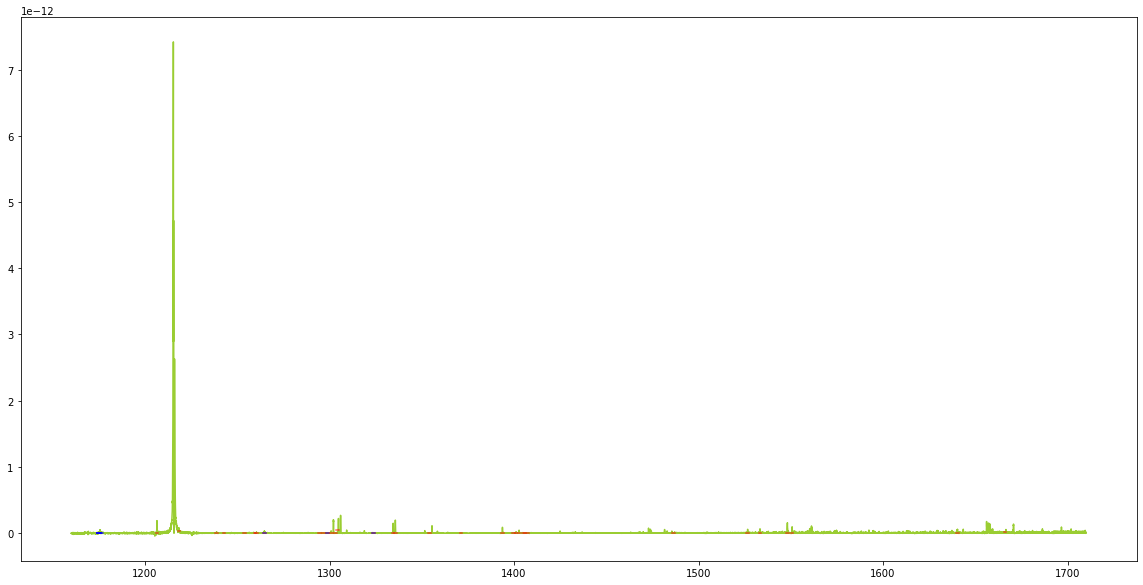

In [138]:
plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask], color="yellowgreen")

# Initializing
flux = defaultdict(list)
count = 0 
iterations = 0
previous_obs = 0 *u.AA
prev_blended_bool = False
prev_left_bound = 0

for wavelength in df['Wavelength']:
    if(wavelength > 1160):        
        continuum = []
        
        # obs_lam calculation from doppler
        rest_lam = wavelength * u.AA
        obs_lam = dv_average.to(u.AA,  equivalencies=u.doppler_optical(rest_lam))
        
        # Check for blended lines
        blended_line_bool = blended_line_check(previous_obs, obs_lam, iterations)
        # Check if previous lam was also a blended line
        if blended_line_bool and prev_blended_bool:
            wavelength_mask = (w > prev_left_bound) & (w < (obs_lam.value + flux_range))
            prev_blended_bool = True
        # If there is a blended line, and previous wasn't a blended line
        elif blended_line_bool:
            wavelength_mask = (w > (previous_obs.value - flux_range)) & (w < (obs_lam.value + flux_range))
            prev_blended_bool = True
            prev_left_bound = previous_obs.value - flux_range
        # Not a blended line
        else:
            wavelength_mask = (w > (obs_lam.value - flux_range)) & (w < (obs_lam.value + flux_range))
            prev_blended_bool = False
        
        # Compute the flux and error
        w0,w1 = wavelength_edges(w[wavelength_mask])
        total_sumflux = np.sum(f[wavelength_mask]*(w1-w0))
        sumerror = (np.sum(e[wavelength_mask]**2 * (w1-w0)**2))**0.5
        
        # Create trendline
        trendline = create_trendline(w[wavelength_mask], f[wavelength_mask], blended_line_bool)

        # Calculate the continuum
        for i in range(0, len(trendline)):
            continuum.append(trendline[i])
        continuum_sumflux = np.sum(continuum*(w1-w0))
        
        # Check if the flux is negative
        total_flux = total_sumflux - continuum_sumflux
        if total_flux <= 0:
            total_flux = sumerror * 3
            sumerror = 0
        
        # If there is a blended line
        if blended_line_bool:
            # Delete the previous flux calculation (check me!) - may need to get rid of [count-1]
            del flux[df['Ion'][count - 1]][previous_index]
            # Add the new flux calculation
            flux[df['Ion'][count]].append(("Wavelength: " + str(wavelength),"Flux: " + str(total_flux), "Error: " + str(sumerror), "Blended line: " + str(blended_line_bool)))
        # If there is not a blended line
        else:
            flux[df['Ion'][count]].append(("Wavelength: " + str(wavelength),"Flux: " + str(total_flux), "Error: " + str(sumerror),"Blended line: " + str(False)))
            
        # Update variables
        previous_obs = obs_lam
        previous_index = len(flux[df['Ion'][count]]) - 1
        iterations+=1
        
    count+=1 
    
# Printing
for ion in flux:
    print(f"Ion: {ion} ")
    for data in flux[ion]:
        print(data)

In [130]:
# Astropy tables
data_array = []

for ion in flux:
    for data in flux[ion]:
        data_array.append({"Ion": ion, "Wavelength": data[0], "Flux": data[1], "Error": data[2], "Blended line": data[3]})

t = Table(rows=data_array)
print(t)
t.write('tau_ceti.ecsv')

 Ion        Wavelength      ...     Blended line   
------ -------------------- ... -------------------
 C III Wavelength: 1175.989 ...  Blended line: True
 C III Wavelength: 1176.372 ... Blended line: False
Si III Wavelength: 1206.499 ... Blended line: False
Si III Wavelength: 1294.543 ... Blended line: False
Si III Wavelength: 1296.726 ... Blended line: False
Si III Wavelength: 1298.944 ...  Blended line: True
Si III Wavelength: 1301.147 ... Blended line: False
Si III Wavelength: 1303.323 ... Blended line: False
  O V]  Wavelength: 1218.39 ... Blended line: False
   N V Wavelength: 1238.821 ... Blended line: False
   ...                  ... ...                 ...
 Si IV  Wavelength: 1402.77 ... Blended line: False
 O IV] Wavelength: 1399.779 ... Blended line: False
 O IV] Wavelength: 1401.171 ... Blended line: False
 O IV] Wavelength: 1407.383 ... Blended line: False
 S IV] Wavelength: 1404.818 ... Blended line: False
 S IV] Wavelength: 1406.016 ... Blended line: False
 N IV] Wavel

Method 2:
- if flux is negative, have the flux be 3 times the error and the error to be 0